<a href="https://colab.research.google.com/github/RubenSchalk/textcorpora/blob/main/i_analyzer_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with I-Analyzer data in R

*Notebook made for the CDH workshop I-Analyzer, October 2022*

Here you'll find some examples on how to import an I-Analyzer export in R, inspect the data, and do some visualizations. You can save this notebook to your own Google drive to work on your own data.

First we load the libraries and import the data. You can import your own data through a Github repository. See [this website](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) for instructions.

The dataset contains a random 1000-row sample of an [I-Analyzer query](https://ianalyzer.hum.uu.nl/search/times;query=revolution%20-%20industrial;$date=1840-01-01:1860-12-31;$ocr=80:100) with keyword 'revolution' - 'industrial', between 1840 and 1860 with an OCR confidence between 80 and 100 per cent.  



In [2]:
install.packages(c("tidytext", "igraph", "ggraph"))

library(ggplot2)
library(tidyverse)
library(data.table)
library(dplyr)
library(tidytext)
library(igraph)
library(ggraph)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SnowballC’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘gridExtra’, ‘RcppArmadillo’, ‘hunspell’, ‘janeaustenr’, ‘tokenizers’, ‘Rcpp’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.4      

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘igra

In [3]:


times <- fread("https://raw.githubusercontent.com/RubenSchalk/textcorpora/main/data/times_sample.csv")

head(times)

edition issue volume date-pub        
1 NA      23295 NA     May 2, 1859     
2 NA      20980 NA     December 9, 1851
3 NA      20006 NA     October 28, 1848
4 NA      23645 NA     June 13, 1860   
5 NA      20003 NA     October 25, 1848
6 NA      19197 NA     March 30, 1846  
  content                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

##Let's make some n-grams!

In [4]:
text <- data.frame(txt = times$content,
                      stringsAsFactors = FALSE)

text %>% 
  unnest_tokens(output = word, input = txt) %>% 
  anti_join(stop_words) %>% 
  count(word, sort = TRUE) %>% top_n(20) 

Joining, by = "word"
Selecting by n


word,n
<chr>,<int>
government,2979
revolution,2567
france,2194
people,1861
country,1791
french,1684
power,1634
de,1553
time,1523


After removal of stopwords, you see that "france", "people", and "government" are mentioned often in the articles. Let's see in what context, i.e. which words were used together?

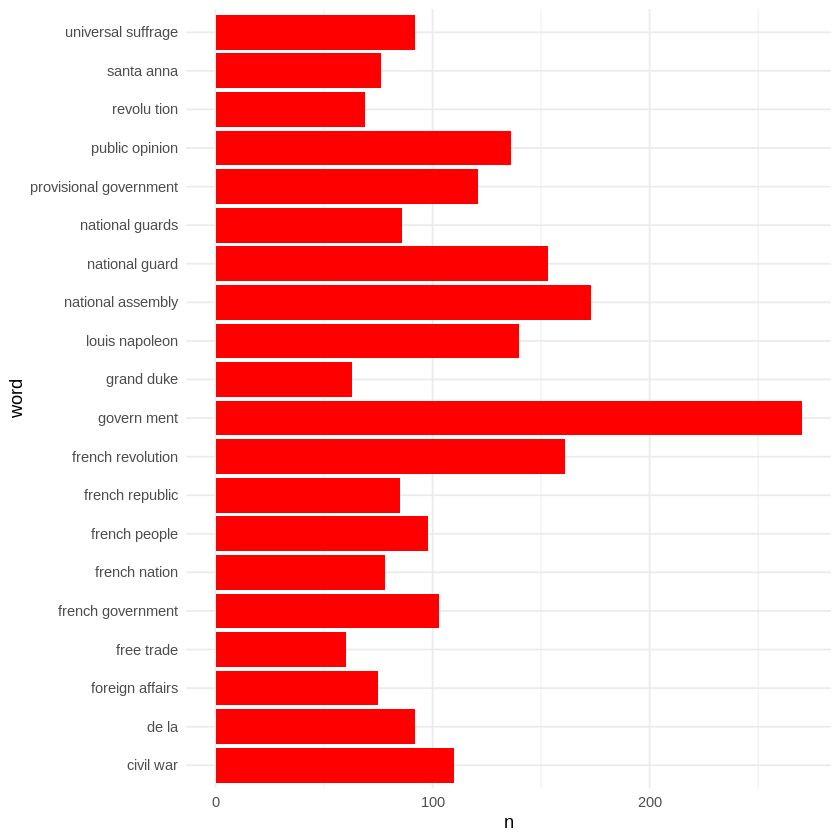

In [10]:
text %>% 
  unnest_tokens(word, txt, token = "ngrams", n = 2) %>% 
  separate(word, c("word1", "word2"), sep = " ") %>% 
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>% 
  unite(word,word1, word2, sep = " ") %>% 
  count(word, sort = TRUE) %>% 
  slice(1:20) %>% 
  ggplot() + geom_bar(aes(word, n), stat = "identity", fill = "#FF0000") +
  theme_minimal() +
  coord_flip()

In [5]:
bigram_counts <- text %>% 
  unnest_tokens(bigram, txt, token = "ngrams", n = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ") %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>%
  filter(!is.na(word1)) %>% 
  filter(!is.na(word2)) %>% 
  count(word1, word2, sort=TRUE)

bigram_counts

bigram_graph <- bigram_counts %>%
  filter(n >= 15) %>%
  graph_from_data_frame()

bigram_graph

word1,word2,n
<chr>,<chr>,<int>
govern,ment,270
national,assembly,173
french,revolution,161
national,guard,153
louis,napoleon,140
public,opinion,136
provisional,government,121
civil,war,110
french,government,103


IGRAPH 9555d65 DN-- 382 290 -- 
+ attr: name (v/c), n (e/n)
+ edges from 9555d65 (vertex names):
 [1] govern     ->ment       national   ->assembly   french     ->revolution
 [4] national   ->guard      louis      ->napoleon   public     ->opinion   
 [7] provisional->government civil      ->war        french     ->government
[10] french     ->people     de         ->la         universal  ->suffrage  
[13] national   ->guards     french     ->republic   french     ->nation    
[16] santa      ->anna       foreign    ->affairs    revolu     ->tion      
[19] grand      ->duke       free       ->trade      louis      ->philippe  
[22] revo       ->lution     vera       ->cruz       austrian   ->government
+ ... omitted several edges

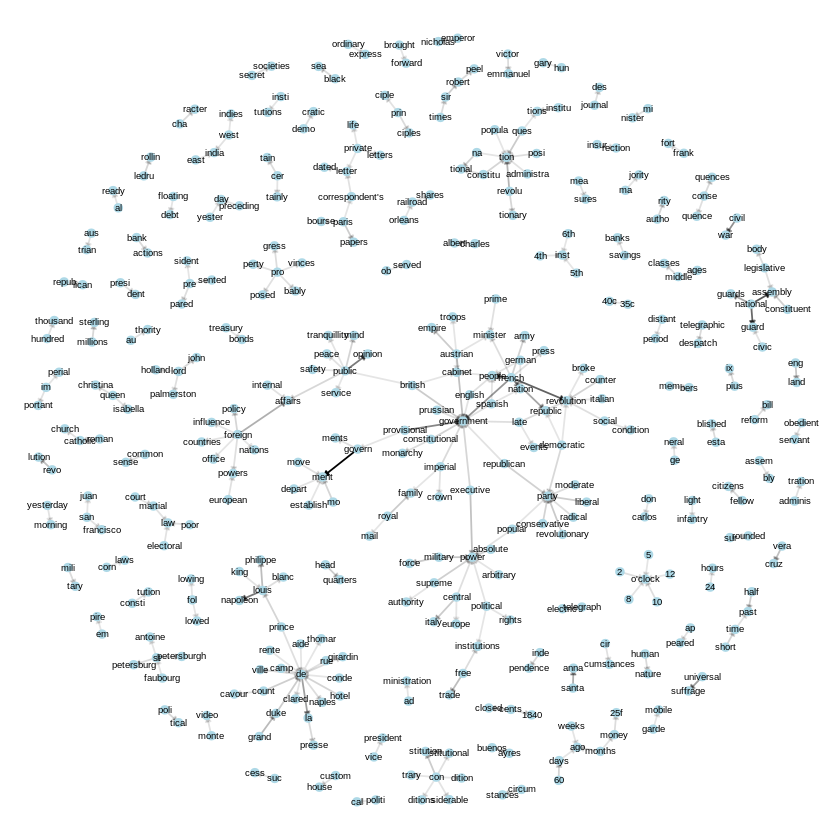

In [14]:
set.seed(1234)

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = grid::arrow(type = "closed", length = unit(1, "mm")), 
                 end_cap = circle(0.5, "mm")) +
  geom_node_point(color = "lightblue", size = 2) +
  geom_node_text(aes(label = name), size = 2) +
  theme_void()